In [14]:
from jupyterthemes import jtplot
import numpy as np
import os
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.ndimage import filters
from textwrap import wrap
import torch

import vectorized_agents as va
import vectorized_env as ve

%matplotlib inline
jtplot.style()

DEVICE = torch.device('cuda')
if DEVICE == torch.device('cpu'):
    os.environ['OMP_NUM_THREADS'] = '4'
    n_envs = 50
else:
    os.environ['OMP_NUM_THREADS'] = '8'
    n_envs = 1000

In [15]:
env_kwargs = dict(
    n_envs=n_envs,
    env_device=DEVICE,
    out_device=DEVICE,
    reward_type=ve.EVERY_STEP_EV_ZEROSUM
)
player_1 = va.SavedRLAgentEnsemble('a3c_agent_small_8_64_32_2', device=DEVICE,
                                   deterministic_policy=True)
#player_2 = va.SavedRLAgentEnsemble('a3c_agent_small_8_32', device=DEVICE,
#                                   deterministic_policy=False)
player_2 = va.PullVegasSlotMachines()

p1_score, rewards_over_time = va.run_vectorized_vs(player_1, player_2, display_out=True, **env_kwargs)
rewards_over_time = rewards_over_time.cpu().numpy().squeeze()

100%|██████████| 1999/1999 [07:59<00:00,  4.17it/s]


SavedRLAgentEnsemble: a3c_agent_small_8_64_32_2_deterministic -vs- PullVegasSlotMachines
Mean scores: 644.77 - 626.59
Match score: 732 - 18 - 250 (73.2% - 1.8% - 25.0%)


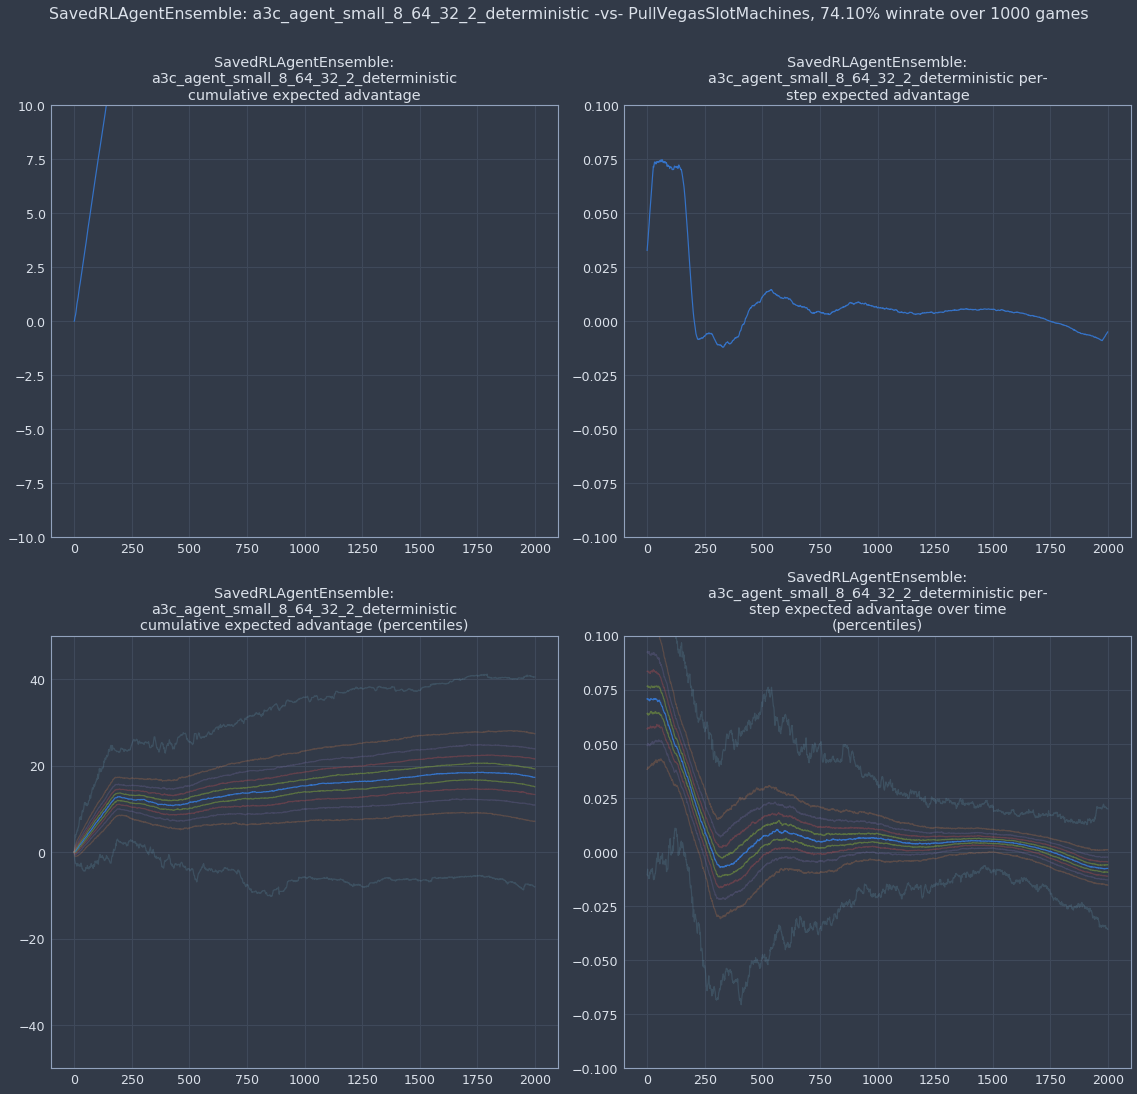

In [16]:
def wrap_title(title):
    return '\n'.join(wrap(title, 45))

cumulative_ymax = 10
expected_ymax = 0.10
q = np.linspace(0., 100., 11)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

n_rows = 2
n_cols = 2
fig, axes = plt.subplots(
    n_rows, n_cols, figsize=(8 * n_cols, 8 * n_rows),
    sharex=False
)
fig_title = f'{player_1.name} -vs- {player_2.name}, {p1_score * 100.:.2f}% winrate over {rewards_over_time.shape[1]} games'
fig.suptitle(fig_title)
axes = axes.ravel()

axes[0].plot(np.cumsum(rewards_over_time.mean(axis=1)))
axes[0].set_ylim((-cumulative_ymax, cumulative_ymax))
axes[0].set_title(wrap_title(f"{player_1.name} cumulative expected advantage"))

window_size = 50
axes[1].plot(filters.uniform_filter1d(rewards_over_time.mean(axis=1), window_size, mode='constant'))
axes[1].set_ylim((-expected_ymax, expected_ymax))
axes[1].set_title(wrap_title(f"{player_1.name} per-step expected advantage"))

for i, quantile, val in zip(range(len(q)), q, np.percentile(np.cumsum(rewards_over_time, axis=0), q, axis=1)):
    color_idx = int(abs((len(q) - 1.) / 2. - i))
    axes[2].plot(val, label=f'Percentile: {quantile:.0f}',
                 color=colors[color_idx],
                 alpha=1./(color_idx + 1),
                 #linewidth=3./(color_idx+1)
                )
axes[2].set_ylim((-cumulative_ymax*5, cumulative_ymax*5))
if len(q) <= 5:
    axes[2].legend()
axes[2].set_title(wrap_title(f"{player_1.name} cumulative expected advantage (percentiles)"))

for i, quantile, val in zip(range(len(q)), q, np.percentile(filters.uniform_filter1d(rewards_over_time, window_size*5, mode='reflect', axis=0), q, axis=1)):
    color_idx = int(abs((len(q) - 1.) / 2. - i))
    axes[3].plot(val, label=f'Percentile: {quantile:.0f}',
                 color=colors[color_idx],
                 alpha=1./(color_idx+1),
                 #linewidth=3./(color_idx+1)
                )
axes[3].set_ylim((-expected_ymax, expected_ymax))
if len(q) <= 5:
    axes[3].legend()
axes[3].set_title(wrap_title(f"{player_1.name} per-step expected advantage over time (percentiles)"))

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

p_names_abbrev = []
for p in (player_1, player_2):
    if type(p) == va.SavedRLAgent:
        p_names_abbrev.append(p.agent_name)
    elif type(p) == va.SavedRLAgentEnsemble:
        p_names_abbrev.append(f'ensemble_{p.ensemble_name}')
    else:
        p_names_abbrev.append(p.name)
save_fig_title = f'{p_names_abbrev[0]}__{p_names_abbrev[1]}'
if type(player_1) == va.SavedRLAgent or type(player_1) == va.SavedRLAgentEnsemble:
    save_fig_folder = f'saved_figures/{p_names_abbrev[0]}'
else:
    save_fig_folder = 'saved_figures'
Path(save_fig_folder).mkdir(exist_ok=True)
fig.savefig(f'{save_fig_folder}/{save_fig_title}.png', dpi=100)
plt.show();

Expected score: 0.99


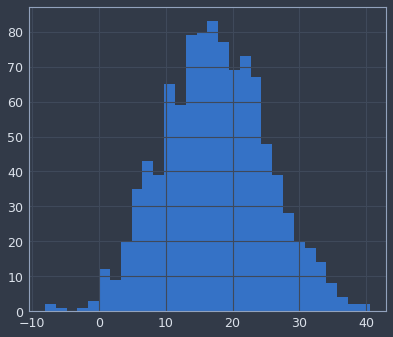

In [17]:
plt.hist(np.cumsum(rewards_over_time, axis=0)[-1, :], bins=30)
print(f'Expected score: {np.mean(np.cumsum(rewards_over_time, axis=0)[-1, :] > 0):.2f}')